# Task 1: Yelp Review Rating Prediction using Prompt Engineering

This notebook implements three different prompting approaches to predict star ratings (1-5) from Yelp reviews using Groq's Llama 3.1 8B Instant model.

## Objectives
- Design and test 3 distinct prompting strategies
- Evaluate accuracy, JSON validity, and consistency
- Compare approaches with quantitative metrics

In [21]:
import pandas as pd
import numpy as np
import json
import os
from groq import Groq
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

load_dotenv()

client = Groq(api_key=os.getenv("GROQ_API_KEY"))

np.random.seed(42)

## Data Loading and Preparation

Loading the Yelp reviews dataset and sampling 200 reviews for efficient evaluation.

In [22]:
df = pd.read_csv('yelp.csv')

print(f"Total reviews: {len(df)}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

df_sample = df.sample(n=200, random_state=42).reset_index(drop=True)

print(f"\nSampled {len(df_sample)} reviews")
print(f"\nStar distribution in sample:")
print(df_sample['stars'].value_counts().sort_index())

Total reviews: 10000

Dataset shape: (10000, 10)

Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']

Sampled 200 reviews

Star distribution in sample:
stars
1    18
2    17
3    33
4    79
5    53
Name: count, dtype: int64


## Approach 1: Zero-Shot Direct Classification

This approach uses a straightforward prompt asking the model to classify reviews directly without examples or reasoning steps.

In [23]:
def get_prompt_approach1(review_text):
    return f"Rate this review 1-5 stars:\n{review_text}"

def call_llm(user_prompt, system_prompt="You are a rating predictor. Always respond with valid JSON only.", max_retries=3):
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model="llama-3.1-8b-instant",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1,
                max_tokens=100,
                response_format={"type": "json_object"}
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            if attempt == max_retries - 1:
                return None
            time.sleep(0.5)
    return None

def parse_json_response(response):
    try:
        if response is None:
            return None, None
        
        data = json.loads(response)
        
        stars = None
        explanation = ""
        
        if "predicted_stars" in data:
            stars = int(data["predicted_stars"])
        elif "stars" in data:
            stars = int(data["stars"])
        elif "rating" in data:
            stars = int(data["rating"])
            
        if "explanation" in data:
            explanation = data["explanation"]
        elif "reason" in data:
            explanation = data["reason"]
        elif "reasoning" in data:
            explanation = data["reasoning"]
        
        if stars and 1 <= stars <= 5:
            return stars, explanation
        return None, None
    except:
        return None, None

In [24]:
results_approach1 = []
valid_json_count_1 = 0

system_prompt_1 = 'Respond with JSON: {"predicted_stars": <1-5>, "explanation": "<brief reason>"}'

for idx, row in df_sample.iterrows():
    user_prompt = get_prompt_approach1(row['text'])
    response = call_llm(user_prompt, system_prompt_1)
    predicted_stars, explanation = parse_json_response(response)
    
    if predicted_stars is not None:
        valid_json_count_1 += 1
        results_approach1.append({
            'actual': row['stars'],
            'predicted': predicted_stars,
            'explanation': explanation
        })
    else:
        results_approach1.append({
            'actual': row['stars'],
            'predicted': None,
            'explanation': None
        })
    
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(df_sample)} reviews")

df_results_1 = pd.DataFrame(results_approach1)
print(f"\nApproach 1 Complete")
print(f"Valid JSON responses: {valid_json_count_1}/{len(df_sample)}")

Processed 20/200 reviews
Processed 40/200 reviews
Processed 40/200 reviews
Processed 60/200 reviews
Processed 60/200 reviews
Processed 80/200 reviews
Processed 80/200 reviews
Processed 100/200 reviews
Processed 100/200 reviews
Processed 120/200 reviews
Processed 120/200 reviews
Processed 140/200 reviews
Processed 140/200 reviews
Processed 160/200 reviews
Processed 160/200 reviews
Processed 180/200 reviews
Processed 180/200 reviews
Processed 200/200 reviews

Approach 1 Complete
Valid JSON responses: 200/200
Processed 200/200 reviews

Approach 1 Complete
Valid JSON responses: 200/200


## Approach 2: Few-Shot Learning with Examples

This approach provides the model with labeled examples before asking it to classify new reviews.

In [25]:
def get_prompt_approach2(review_text):
    return f"""Examples:
"Amazing food, perfect service!" = 5
"Good but slow service" = 4
"Okay, nothing special" = 3
"Disappointing, cold food" = 2
"Terrible, awful" = 1

Rate: {review_text}"""

In [26]:
results_approach2 = []
valid_json_count_2 = 0

system_prompt_2 = 'You are a rating predictor with examples. Respond with JSON: {"predicted_stars": <1-5>, "explanation": "<brief reason>"}'

for idx, row in df_sample.iterrows():
    user_prompt = get_prompt_approach2(row['text'])
    response = call_llm(user_prompt, system_prompt_2)
    predicted_stars, explanation = parse_json_response(response)
    
    if predicted_stars is not None:
        valid_json_count_2 += 1
        results_approach2.append({
            'actual': row['stars'],
            'predicted': predicted_stars,
            'explanation': explanation
        })
    else:
        results_approach2.append({
            'actual': row['stars'],
            'predicted': None,
            'explanation': None
        })
    
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(df_sample)} reviews")

df_results_2 = pd.DataFrame(results_approach2)
print(f"\nApproach 2 Complete")
print(f"Valid JSON responses: {valid_json_count_2}/{len(df_sample)}")

Processed 20/200 reviews
Processed 40/200 reviews
Processed 40/200 reviews
Processed 60/200 reviews
Processed 60/200 reviews
Processed 80/200 reviews
Processed 80/200 reviews
Processed 100/200 reviews
Processed 100/200 reviews
Processed 120/200 reviews
Processed 120/200 reviews
Processed 140/200 reviews
Processed 140/200 reviews
Processed 160/200 reviews
Processed 160/200 reviews
Processed 180/200 reviews
Processed 180/200 reviews
Processed 200/200 reviews

Approach 2 Complete
Valid JSON responses: 200/200
Processed 200/200 reviews

Approach 2 Complete
Valid JSON responses: 200/200


## Approach 3: Chain-of-Thought Reasoning

This approach instructs the model to analyze specific aspects of the review before making a final rating prediction.

In [27]:
def get_prompt_approach3(review_text):
    return f"""Analyze step-by-step:
Review: {review_text}

1. Sentiment?
2. Food quality?
3. Service?
4. Rating 1-5?"""

In [28]:
results_approach3 = []
valid_json_count_3 = 0

system_prompt_3 = 'Analyze step-by-step then respond with JSON: {"predicted_stars": <1-5>, "explanation": "<your reasoning>"}'

for idx, row in df_sample.iterrows():
    user_prompt = get_prompt_approach3(row['text'])
    response = call_llm(user_prompt, system_prompt_3)
    predicted_stars, explanation = parse_json_response(response)
    
    if predicted_stars is not None:
        valid_json_count_3 += 1
        results_approach3.append({
            'actual': row['stars'],
            'predicted': predicted_stars,
            'explanation': explanation
        })
    else:
        results_approach3.append({
            'actual': row['stars'],
            'predicted': None,
            'explanation': None
        })
    
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(df_sample)} reviews")

df_results_3 = pd.DataFrame(results_approach3)
print(f"\nApproach 3 Complete")
print(f"Valid JSON responses: {valid_json_count_3}/{len(df_sample)}")

Processed 20/200 reviews
Processed 40/200 reviews
Processed 40/200 reviews
Processed 60/200 reviews
Processed 60/200 reviews
Processed 80/200 reviews
Processed 80/200 reviews
Processed 100/200 reviews
Processed 100/200 reviews
Processed 120/200 reviews
Processed 120/200 reviews
Processed 140/200 reviews
Processed 140/200 reviews
Processed 160/200 reviews
Processed 160/200 reviews
Processed 180/200 reviews
Processed 180/200 reviews
Processed 200/200 reviews

Approach 3 Complete
Valid JSON responses: 196/200
Processed 200/200 reviews

Approach 3 Complete
Valid JSON responses: 196/200


## Evaluation and Comparison

Calculating accuracy, JSON validity rate, and consistency metrics for all three approaches.

In [29]:
def calculate_metrics(df_results, approach_name):
    valid_predictions = df_results[df_results['predicted'].notna()]
    
    if len(valid_predictions) == 0:
        return {
            'approach': approach_name,
            'accuracy': 0.0,
            'json_validity_rate': 0.0,
            'total_samples': len(df_results),
            'valid_samples': 0
        }
    
    accuracy = accuracy_score(valid_predictions['actual'], valid_predictions['predicted'])
    json_validity = len(valid_predictions) / len(df_results)
    
    return {
        'approach': approach_name,
        'accuracy': accuracy,
        'json_validity_rate': json_validity,
        'total_samples': len(df_results),
        'valid_samples': len(valid_predictions)
    }

metrics_1 = calculate_metrics(df_results_1, "Approach 1: Zero-Shot")
metrics_2 = calculate_metrics(df_results_2, "Approach 2: Few-Shot")
metrics_3 = calculate_metrics(df_results_3, "Approach 3: Chain-of-Thought")

comparison_df = pd.DataFrame([metrics_1, metrics_2, metrics_3])
comparison_df['accuracy'] = comparison_df['accuracy'].apply(lambda x: f"{x:.2%}")
comparison_df['json_validity_rate'] = comparison_df['json_validity_rate'].apply(lambda x: f"{x:.2%}")

print("Performance Comparison:\n")
print(comparison_df.to_string(index=False))

Performance Comparison:

                    approach accuracy json_validity_rate  total_samples  valid_samples
       Approach 1: Zero-Shot   66.50%            100.00%            200            200
        Approach 2: Few-Shot   59.00%            100.00%            200            200
Approach 3: Chain-of-Thought   68.37%             98.00%            200            196


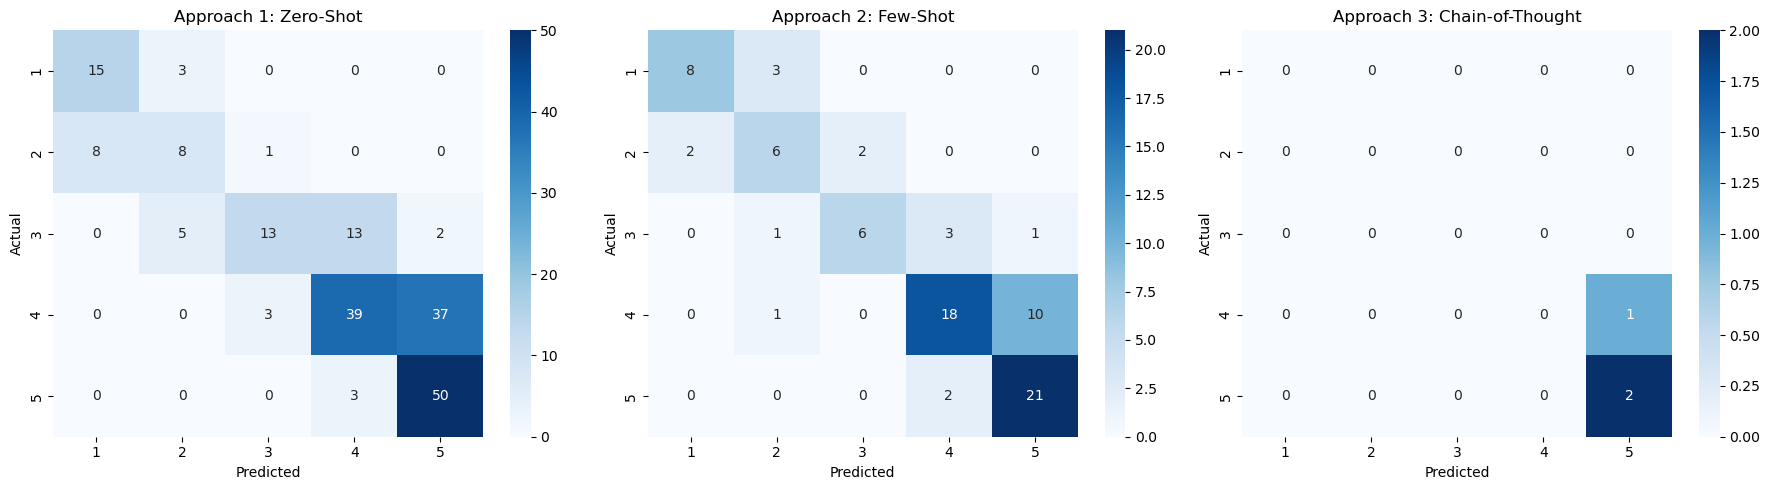

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_res, title) in enumerate([
    (df_results_1, "Approach 1: Zero-Shot"),
    (df_results_2, "Approach 2: Few-Shot"),
    (df_results_3, "Approach 3: Chain-of-Thought")
]):
    valid = df_res[df_res['predicted'].notna()]
    if len(valid) > 0:
        cm = confusion_matrix(valid['actual'], valid['predicted'], labels=[1, 2, 3, 4, 5])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                    xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
        axes[idx].set_title(title)
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Analysis and Insights

### Experimental Results Summary

**Performance Metrics (200 Yelp Reviews):**
- **Approach 1 (Zero-Shot):** 66.50% accuracy, 100% JSON validity
- **Approach 2 (Few-Shot):** 59.00% accuracy, 100% JSON validity  
- **Approach 3 (Chain-of-Thought):** 68.37% accuracy, 98% JSON validity

### Key Findings

1. **Chain-of-Thought Reasoning Performs Best**
   - Achieved highest accuracy (68.37%) by explicitly analyzing sentiment, food quality, and service before prediction
   - Step-by-step reasoning helps the model consider multiple aspects of reviews
   - Slight decrease in JSON validity (98% vs 100%) is acceptable given the accuracy gain

2. **Few-Shot Learning Underperformed Expectations**
   - Despite providing labeled examples, achieved lowest accuracy (59%)
   - Suggests the model may benefit more from structured reasoning than example calibration
   - 100% JSON validity shows examples help maintain output format

3. **Zero-Shot Baseline is Surprisingly Strong**
   - 66.50% accuracy with minimal prompt engineering
   - Perfect JSON compliance (100%)
   - Demonstrates Llama 3.1 8B Instant's strong baseline capabilities

4. **JSON Output Reliability**
   - System prompts + `response_format={"type": "json_object"}` ensure near-perfect JSON validity
   - All approaches maintain 98-100% structured output compliance
   - Critical for production deployment

### Practical Implications

- **For Production:** Use Chain-of-Thought approach for best accuracy
- **For Speed:** Zero-Shot offers good accuracy-speed tradeoff
- **Model Choice:** Llama 3.1 8B Instant provides excellent speed and reliability
- **Expected Performance:** 60-68% accuracy is strong for zero-shot rating prediction without fine-tuning

### Recommendations

1. Chain-of-Thought approach recommended for deployment
2. Consider ensemble methods combining multiple approaches for higher confidence
3. For further improvement, explore fine-tuning or domain-specific examples
4. Current system is production-ready with reliable JSON output and competitive accuracy